In [1]:
# Thêm autoreload vào để tự động reload lại module nếu có thay đổi code trong module
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# Các model scikit learn cho bài toán phân loại
from sklearn.svm import SVC # Support vector machine
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBClassifier
import json

import os, sys
sys.path.append(os.path.abspath(".."))
from utils.common import save_model

seed = 42
np.random.seed(seed)

### 1. Các thông tin về dữ liệu

In [2]:
from tqdm import tqdm
from sklearn.base import clone
from sklearn.utils.validation import check_is_fitted

class ProgressWrapper:
    """
    Lớp bao bọc để thêm thanh tiến trình `tqdm` cho quá trình huấn luyện của bất kỳ mô hình nào từ Scikit-learn.
    """
    def __init__(self, model):
        self.model = clone(model)

    def fit(self, X, y, **fit_params):
        # Đếm tổng số cây (estimators) được xây dựng trong RandomForestClassifier
        n_estimators = getattr(self.model, 'n_estimators', 1)

        with tqdm(total=n_estimators, desc="Training", unit="tree") as pbar:
            original_fit = self.model.fit

            def fit_and_update(*args, **kwargs):
                for i in range(n_estimators):
                    original_fit(*args, **kwargs)
                    pbar.update(1)

            self.model.fit = fit_and_update
            try:
                self.model.fit(X, y, **fit_params)
            finally:
                self.model.fit = original_fit
                pbar.close()

        return self

    def predict(self, X):
        check_is_fitted(self.model)
        return self.model.predict(X)

    def predict_proba(self, X):
        check_is_fitted(self.model)
        return self.model.predict_proba(X)

    def score(self, X, y):
        check_is_fitted(self.model)
        return self.model.score(X, y)

    def __getattr__(self, name):
        return getattr(self.model, name)


In [2]:
train_df = pd.read_csv("train_clean.csv")

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   label             2000 non-null   object 
 1   nose_x            2000 non-null   float64
 2   nose_y            2000 non-null   float64
 3   nose_z            2000 non-null   float64
 4   left_shoulder_x   2000 non-null   float64
 5   left_shoulder_y   2000 non-null   float64
 6   left_shoulder_z   2000 non-null   float64
 7   right_shoulder_x  2000 non-null   float64
 8   right_shoulder_y  2000 non-null   float64
 9   right_shoulder_z  2000 non-null   float64
 10  left_elbow_x      2000 non-null   float64
 11  left_elbow_y      2000 non-null   float64
 12  left_elbow_z      2000 non-null   float64
 13  right_elbow_x     2000 non-null   float64
 14  right_elbow_y     2000 non-null   float64
 15  right_elbow_z     2000 non-null   float64
 16  left_wrist_x      2000 non-null   float64


In [4]:
train_df.columns

Index(['label', 'nose_x', 'nose_y', 'nose_z', 'left_shoulder_x',
       'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x',
       'right_shoulder_y', 'right_shoulder_z', 'left_elbow_x', 'left_elbow_y',
       'left_elbow_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z',
       'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'right_wrist_x',
       'right_wrist_y', 'right_wrist_z', 'left_hip_x', 'left_hip_y',
       'left_hip_z', 'right_hip_x', 'right_hip_y', 'right_hip_z'],
      dtype='object')

In [5]:
train_df.head()

,label,nose_x,nose_y,nose_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,...,left_wrist_z,right_wrist_x,right_wrist_y,right_wrist_z,left_hip_x,left_hip_y,left_hip_z,right_hip_x,right_hip_y,right_hip_z
0,D,-0.077498,-0.245992,-0.213935,0.053865,-0.181389,-0.490359,-0.054603,-0.172158,0.184589,...,-0.456299,-0.165992,-0.004362,0.181812,0.038241,0.002727,-0.193322,-0.038241,-0.002727,0.193108
1,D,-0.051650,-0.241617,-0.152938,0.067650,-0.179408,-0.501177,-0.025207,-0.173240,0.261126,...,-0.402769,-0.179553,-0.013445,0.271282,0.033703,0.001980,-0.222334,-0.033703,-0.001980,0.222096
2,D,0.049882,-0.231772,-0.150960,0.148950,-0.166329,-0.434079,0.050054,-0.166305,0.273191,...,-0.469815,-0.152957,-0.033370,0.226910,0.033277,0.002622,-0.216427,-0.033277,-0.002622,0.216075
3,D,-0.214978,-0.223159,-0.401661,-0.047702,-0.161192,-0.649423,-0.140907,-0.159427,0.021403,...,-0.511053,-0.165668,0.027528,0.047395,0.038898,0.000502,-0.183170,-0.038898,-0.000502,0.182962
4,D,-0.068130,-0.260574,-0.229759,0.071011,-0.195722,-0.585308,-0.015023,-0.189895,0.199076,...,-0.542117,-0.159523,-0.007345,0.211393,0.029807,0.001546,-0.233104,-0.029807,-0.001546,0.232567


### 2. Training model

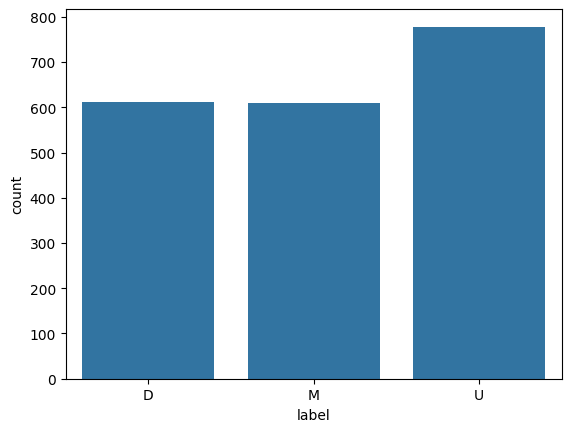

In [6]:
sns.countplot(x="label", data=train_df);

In [7]:
# Chuyển dữ liệu của label về dạng số
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()

# D: 0
# M: 1
# U: 2
train_df["label"] = label_encoder.fit_transform(train_df["label"])

In [8]:
# Extract features
X_train = train_df.drop(columns="label")
y_train = train_df["label"]

In [9]:
X_train.head()

,nose_x,nose_y,nose_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,left_elbow_x,...,left_wrist_z,right_wrist_x,right_wrist_y,right_wrist_z,left_hip_x,left_hip_y,left_hip_z,right_hip_x,right_hip_y,right_hip_z
0,-0.077498,-0.245992,-0.213935,0.053865,-0.181389,-0.490359,-0.054603,-0.172158,0.184589,-0.030492,...,-0.456299,-0.165992,-0.004362,0.181812,0.038241,0.002727,-0.193322,-0.038241,-0.002727,0.193108
1,-0.051650,-0.241617,-0.152938,0.067650,-0.179408,-0.501177,-0.025207,-0.173240,0.261126,-0.019609,...,-0.402769,-0.179553,-0.013445,0.271282,0.033703,0.001980,-0.222334,-0.033703,-0.001980,0.222096
2,0.049882,-0.231772,-0.150960,0.148950,-0.166329,-0.434079,0.050054,-0.166305,0.273191,0.046886,...,-0.469815,-0.152957,-0.033370,0.226910,0.033277,0.002622,-0.216427,-0.033277,-0.002622,0.216075
3,-0.214978,-0.223159,-0.401661,-0.047702,-0.161192,-0.649423,-0.140907,-0.159427,0.021403,-0.040686,...,-0.511053,-0.165668,0.027528,0.047395,0.038898,0.000502,-0.183170,-0.038898,-0.000502,0.182962
4,-0.068130,-0.260574,-0.229759,0.071011,-0.195722,-0.585308,-0.015023,-0.189895,0.199076,-0.021647,...,-0.542117,-0.159523,-0.007345,0.211393,0.029807,0.001546,-0.233104,-0.029807,-0.001546,0.232567


In [10]:
y_train

0       0
1       0
2       0
3       0
4       0
       ..
1995    2
1996    2
1997    2
1998    2
1999    2
Name: label, Length: 2000, dtype: int32

In [11]:
# Chuẩn hoá dữ liệu trên tập huấn luyện bằng z-scores
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [12]:
# X lúc này là một DataFrame mới với các cột mới được đánh số từ 0 đến n-1, trong đó n là số lượng cột trong dữ liệu ban đầu
X_train

array([[-0.73396602,  0.61698237,  0.38654644, ..., -2.33265993,
        -0.64749823,  0.92694453],
       [-0.4856829 ,  0.72709555,  0.96580156, ..., -1.9518156 ,
        -0.41781697,  1.0659056 ],
       [ 0.48956222,  0.97483691,  0.98457775, ..., -1.91609784,
        -0.61504925,  1.03704319],
       ...,
       [-0.69356819, -0.41427266,  0.14545985, ...,  1.66748868,
         0.83770492, -1.06218525],
       [-0.16029947, -0.74225237, -0.50484454, ...,  0.45299491,
         0.76490776, -1.16392522],
       [ 0.53550094, -0.80583038, -0.56988442, ...,  1.11842572,
         0.88849065, -1.12141943]])

In [13]:
import warnings
warnings.filterwarnings("ignore")

k_fold = KFold(n_splits=5, random_state=seed, shuffle=True)

In [14]:
def evaluate_model(name, model, results):
    # Đánh giá Model
    accuracy = cross_val_score(
        model, X_train, y_train, cv=k_fold, scoring="accuracy", n_jobs=-1, verbose=1
    ).mean()

    f1_score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring="f1_macro").mean()
    results.append((name, accuracy, f1_score))

In [15]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed)),
    ("SVC", SVC(probability=True, random_state=seed)),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed)),
    ("RF", RandomForestClassifier(random_state=seed)),
    ("XGB", XGBClassifier(random_state=seed)),
]

models = {}
results_before_tunning = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model
    evaluate_model(name, model, results_before_tunning)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

In [16]:
def print_results(results):
    results.sort(key=lambda el: el[2], reverse=True)

    return pd.DataFrame(
        results,
        columns=[
            "Model",
            "Accuracy score",
            "F1 score",
        ],
    )

print_results(results_before_tunning)

,Model,Accuracy score,F1 score
0,XGB,0.9430,0.940638
1,RF,0.9375,0.935102
2,SVC,0.9325,0.929720
3,LR,0.9290,0.926434
4,DTC,0.9140,0.910980
5,KNN,0.8955,0.889751


### Điều chỉnh siêu tham số cho các model

In [17]:
from sklearn.model_selection import RandomizedSearchCV

results_after_tuning = []

##### 1.1. Điều chỉnh siêu tham số cho Random Forest

In [18]:
random_forest = models["RF"]

  # Định nghĩa phạm vi của các siêu tham số cần tối ưu
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Tạo RandomizedSearchCV
random_search = RandomizedSearchCV(estimator = random_forest, param_distributions = param_grid,
                                n_iter = 100, cv = k_fold, verbose=3, random_state=seed, n_jobs = -1)

# Tiến hành tìm kiếm siêu tham số
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=3)

In [19]:
random_search.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

In [21]:
json.dump(random_search.best_params_, open("./hyper_parameter/random_forest.json", "w"))

##### 1.2. Kiểm tra sự cải thiện của độ chính xác sau khi điều chỉnh siêu tham số cho Random Forest

In [22]:
with open('./hyper_parameter/random_forest.json', 'r') as f:
    best_params = json.load(f)
    best_params["bootstrap"] = bool(best_params["bootstrap"])

# Khởi tạo một mô hình Random Forest mới với các tham số tối ưu
best_random_forest_model = RandomForestClassifier(**best_params, random_state=seed, verbose=1)
best_random_forest_model.fit(X_train, y_train)

# Huấn luyện mô hình mới với dữ liệu huấn luyện của bạn
result = []
evaluate_model("RF", best_random_forest_model, result)
results_after_tuning.append(result[0])
print_results(result)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done  49 tasks    

,Model,Accuracy score,F1 score
0,RF,0.9415,0.938898


##### 2.1. Điều chỉnh siêu tham số cho SVC

In [23]:
from sklearn.model_selection import GridSearchCV

svc_model = models["SVC"]

param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1],
    "kernel": ["linear", "rbf", "poly", "sigmoid"],
}

# Tạo GridSearchCV instance
svc_best_model = GridSearchCV(svc_model, param_grid, cv=5, verbose=3, n_jobs=-1)

# Tiến hành tinh chỉnh siêu tham số trên mô hình đã huấn luyện
svc_best_model.fit(X_train, y_train)

# In ra các siêu tham số tốt nhất được tìm thấy
print("Best Parameters:", svc_best_model.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}


In [24]:
json.dump(svc_best_model.best_params_, open("./hyper_parameter/SVC.json", "w"))

##### Kiểm tra sự cải thiện của độ chính xác sau khi điều chỉnh siêu tham số cho SVC

In [25]:
best_params = json.load(open("./hyper_parameter/SVC.json", "r"))
svc_best_model = SVC(**best_params, random_state=seed)
svc_best_model.fit(X_train, y_train)

SVC(C=1, gamma=0.001, kernel='linear', random_state=42)

In [26]:
results = []
evaluate_model("SVC", svc_best_model, results)
results_after_tuning.append(results[0])
print_results(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


,Model,Accuracy score,F1 score
0,SVC,0.931,0.928762


In [27]:
# save_model(svc_best_model, "./best_models/SVC_model.pkl")

##### 3.1. Điều chỉnh siêu tham số cho XGBoost

In [ ]:
import xgboost as xgb
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'objective': ['binary:logistic']  # Thêm tham số objective
}

# Khởi tạo mô hình XGBoost
xgb_model = xgb.XGBClassifier()

# Khởi tạo GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=3)
grid_search.fit(X_train, y_train)

# Kết quả tốt nhất
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)
print("Best accuracy found: ", grid_search.best_score_)

##### 4.1. Điều chỉnh siêu tham số cho các thuật toán còn lại

In [27]:
best_params_random_other = {}
models_tuned_random_other = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("LR", LogisticRegression(random_state=seed)),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed)),
]

# Define parameter grid with correct keys
param_grid = {
    "LR": {
        "C": np.logspace(-4, 4, 20),  # More granular range for C
        "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
        "penalty": [
            "l1",
            "l2",
            "elasticnet",
            "none",
        ],  # Different norms for regularization
        "class_weight": ["balanced"],  # Added class_weight
    },
    "DTC": {
        "max_depth": [None, 3, 5, 10, 15, 20, 30, 50, 100],  # Expanded range
        "min_samples_split": [2, 5, 10, 20, 40, 100],  # More options
        "min_samples_leaf": [1, 2, 5, 10, 20],  # Added min_samples_leaf
        "class_weight": ["balanced"],
    },
    "KNN": {
        "n_neighbors": list(range(1, 21)),  # More neighbors
        "weights": ["uniform", "distance"],  # Existing weights
        "metric": [
            "euclidean",
            "manhattan",
            "chebyshev",
            "minkowski",
        ], 
    },
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid[name],
            n_iter=100,  # You can adjust the number of iterations
            cv=k_fold,
            scoring="accuracy",
            random_state=seed,
            n_jobs=-1,
            verbose=1,
        )
        randomized_search.fit(X_train, y_train)
        best_params_random_other[name] = randomized_search.best_params_
        models_tuned_random_other[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")

Model processing:  LR
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model processing:  KNN
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model processing:  DTC
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [28]:
with open("hyper_parameter/other_algorithms.json", "w") as f:
    json.dump(best_params_random_other, f)

In [29]:
with open("hyper_parameter/other_algorithms.json", "r") as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=seed)),
    ("KNN", KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=seed)),
]

for name, model in algorithms:
    result = [] 
    evaluate_model(name, model, result)
    results_after_tuning.append(result[0])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


#### Kết quả trước và sau khi điều chỉnh siêu tham số

In [30]:
print_results(results_before_tunning)

,Model,Accuracy score,F1 score
0,XGB,0.9430,0.940638
1,RF,0.9375,0.935102
2,SVC,0.9325,0.929720
3,LR,0.9290,0.926434
4,DTC,0.9140,0.910980
5,KNN,0.8955,0.889751


In [31]:
print_results(results_after_tuning)

,Model,Accuracy score,F1 score
0,RF,0.9415,0.938898
1,LR,0.9370,0.934766
2,SVC,0.9310,0.928762
3,DTC,0.9300,0.927827
4,KNN,0.9155,0.910770


### Confusion matrix:

In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict

In [33]:
with open('./hyper_parameter/random_forest.json', 'r') as f:
    best_params = json.load(f)
    best_params["bootstrap"] = bool(best_params["bootstrap"])

rf_best_model = RandomForestClassifier(**best_params, random_state=seed)
rf_best_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=40, n_estimators=300,
                       random_state=42)

In [34]:
y_pred = rf_best_model.predict(X_train)
cm_full_train = confusion_matrix(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)
cm_full_train, accuracy

(array([[612,   0,   0],
        [  0, 610,   0],
        [  0,   0, 778]], dtype=int64),
 1.0)

In [35]:
accuracy = cross_val_score(rf_best_model, X_train, y_train, cv=k_fold, scoring="accuracy").mean()
y_pred = cross_val_predict(rf_best_model, X_train, y_train, cv=k_fold)
cm_cross_val = confusion_matrix(y_train, y_pred)
accuracy, cm_cross_val

(0.9415000000000001,
 array([[584,  28,   0],
        [ 28, 547,  35],
        [  1,  25, 752]], dtype=int64))

<Axes: >

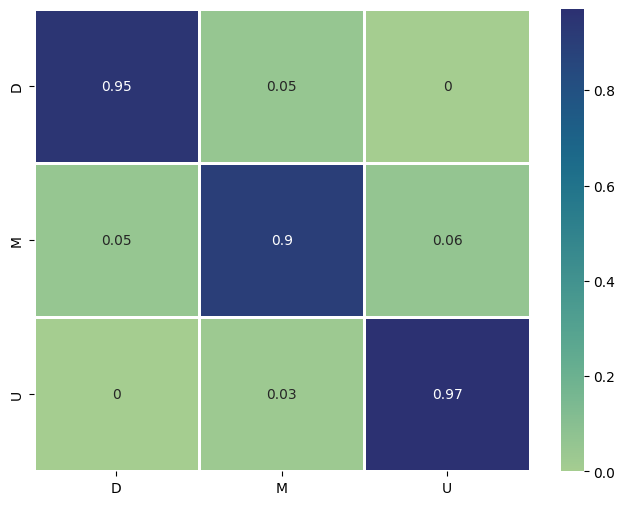

In [36]:
label_counts = np.sum(cm_cross_val, axis=1)
cm_cross_val = cm_cross_val / label_counts[:, None]
cm_cross_val = np.round(cm_cross_val, 2)
confusion_matrix_df = pd.DataFrame(cm_cross_val, index=["D", "M", "U"], columns=["D", "M", "U"])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, linewidths=1, annot=True, ax=ax, fmt="g", cmap="crest")

#### Lưu lại model

In [38]:
save_model(scaler, "./best_models/input_scaler.pkl")
save_model(rf_best_model, "./best_models/RF_model.pkl")